In [2]:
import torch
import torch.nn as nn   
import tiktoken

Causal Attention

In [3]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

Multihead attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)   #reshape from 1,3,6 to 1,3,2,3 (1 batch of 3 token having 2 heads of 3 dimensions each)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # now these are grouped by head , each head contains all the token in the emb dimenions
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)  #keys.shape[-1] is head_dim
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [5]:
import sys
print(sys.version)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]


In [6]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

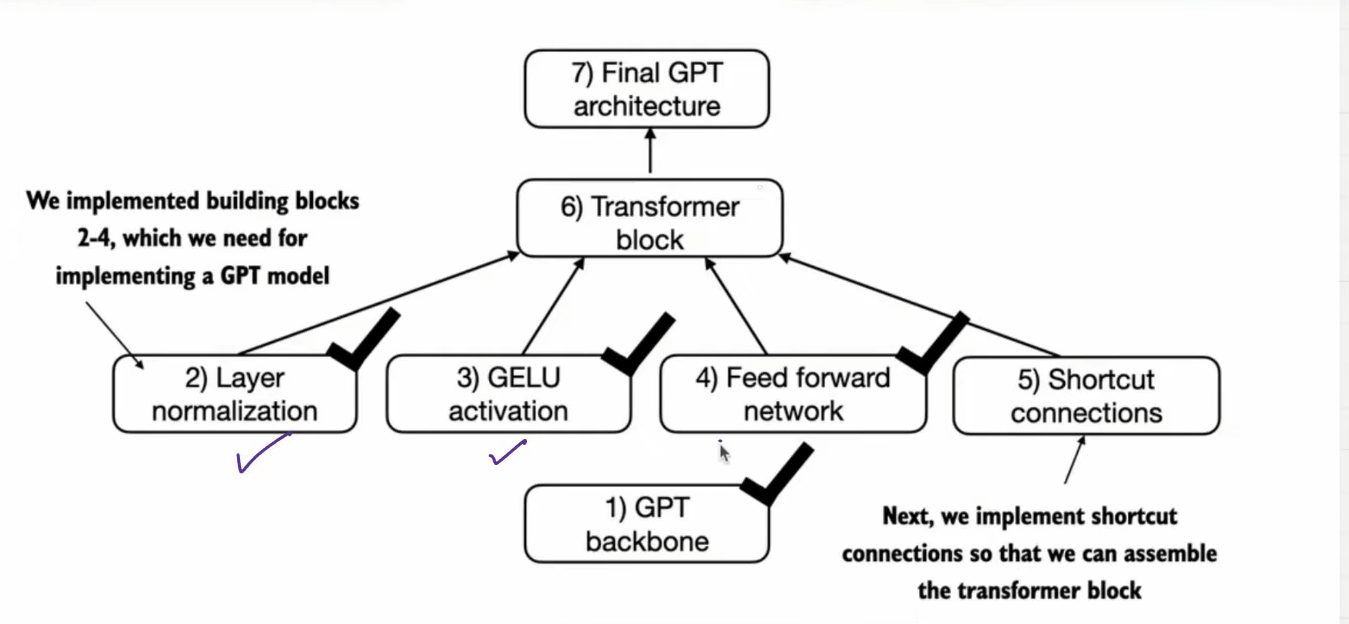

In [ ]:
class DummyGPTv1(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.position_embedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"])   # we are going to look at context length i.e number of words lets say in a sentence we want to know position with is 1024, is context length. 
        self.drop_emb= nn.Dropout(cfg["dropout"])
        self.trf_block= nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])  #stacking transformer blocks
        self.final_norm= NormalizationLayer(cfg["emb_dim"])
        self.out_layer=nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)   # final output layer to get the probabilities of each token in the vocabulary
    
    
    def forward(self, input):
        batch_size, seq_length = input.size()
        token_emb=self.token_embedding(input)   # we are looking for these inputs in the embedding metrics that we have created
        position_emb=self.position_embedding(torch.arange(seq_length,device=input.device))  # it will look at the token length (lets say 4) and then find from (0,1,2,3) the position embedding vector for each token from the position embedding matrix defined in class 
        x= token_emb + position_emb
        x=self.drop_emb(x)
        x=self.trf_block(x)   # passing through transformer blocks
        x=self.final_norm(x)
        logits=self.out_layer(x)
        # final output layer
        return logits  #return probabilities of all token in the vocabulary for each Input word position in the sequence to predict what comes next, so size will be token size (here 4) and since dictonary size is 50257, so (4,50257) will be the output size.
        

        

class NormalizationLayer(nn.Module):
    def __init__(self, cfg):    
        super().__init__()    
    def forward(self, x):
        return x
    

In [7]:
tokenizer= tiktoken.get_encoding("gpt2")
batch=[]
txt1= "Every effort moves you"
txt2= "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch= torch.stack(batch, dim=0) # stacking into batch of size 2
print(batch) 




tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [66]:
torch.manual_seed(123)
model= DummyGPTv1(GPT_Config_124M)

logits= model(batch)

print("Logits size:", logits.size())  # expect (batch size, sequence length, vocab size) => (2, 5, 50257)
print("Logits:", logits)

Hers is the token embedding  tensor([[[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]],

        [[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-0.7858,  0.0101,  1.2537,  ..., -0.2667, -0.7853,  1.3047],
         [ 1.8873,  0.7559, -0.1797,  ..., -0.0418, -0.4365, -0.3167],
         [ 1.2758, -0.2896,  0.9539,  ...,  0.3405, -1.0636, -0.0674]]],
       grad_fn=<EmbeddingBackward0>)
token embedding shape: torch.Size([2, 4, 768])
Logits size: torch.Size([2, 4, 50257])
Logits: tensor([[[ 6.5946e-02, -1.1929e-01, -7.9099e-01,  ...,  1.2629e-01,
          -1.5540e-02,  2.0410e-01],
         [ 2.2328e-01, -1.3943e+00, -1.0438e+00,  ..., -5.4408e-01,
           7.9521e-01, -7.9811e-01],
         [ 9.2953e-01, -2.9704e-01,  1.0636e-01,  ...,  2.

Layer Normalization

In [8]:
torch.manual_seed(123)
batch_example= torch.randn(2,4) # two batch each of  5 columns
layer= nn.Sequential(nn.Linear(4,6), nn.ReLU())  # sequential layers taking 5 inputs one by one batch and giving 6 outputs
out= layer(batch_example)
print(out)




tensor([[0.0000, 0.0000, 0.0000, 0.1585, 0.0000, 0.1680],
        [0.4252, 0.0000, 0.2041, 0.0000, 0.0000, 0.8094]],
       grad_fn=<ReluBackward0>)


In [8]:
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean=out.mean(axis = -1, keepdim=True)
std=out.std(axis = -1, keepdim=True)
out_normalized= (out - mean) / (std + 0.00001)
print(out_normalized)

tensor([[ 0.6158,  1.4125, -0.8718,  0.5872, -0.8718, -0.8718],
        [-0.0189,  0.1121, -1.0876,  1.5172,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)


In [9]:
class LayerNormalization(nn.Module):
    def __init__(self,normalized_shape, eps=0.00001):  # normalized_shape is usually the number of dimesions of embedding 
        # since normalization doesnt change the dimesion 
        super().__init__()
        self.eps= eps
        self.gamma= nn.Parameter(torch.ones(normalized_shape))  # scale parameter
        self.beta= nn.Parameter(torch.zeros(normalized_shape))  # shift parameter
       
    def forward(self, x):
        mean=x.mean(axis=-1, keepdim=True)
        std=x.std(axis=-1, keepdim=True)
        out_normalized= (x - mean) / torch.sqrt (std + self.eps)
        #return out_normalized
        return self.gamma * out_normalized + self.beta  # scale and shift
    

In [7]:
norm= LayerNormalization((4))
batch_example= torch.randn(2,4)
normalized_output= norm.forward(batch_example)
batch_example.shape


torch.Size([2, 4])

In [8]:
print(normalized_output)
normalized_output.shape

tensor([[ 0.6504,  0.4717, -1.1268,  0.0047],
        [ 1.0577,  0.3548, -1.2910, -0.1215]], grad_fn=<AddBackward0>)


torch.Size([2, 4])

Writing Gelu Activation function

In [10]:
class GeluActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1+ torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * 
            (x + 0.044715 * torch.pow(x,3))))  # approcximation of gelu

In [11]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

Sequential Module works this way :

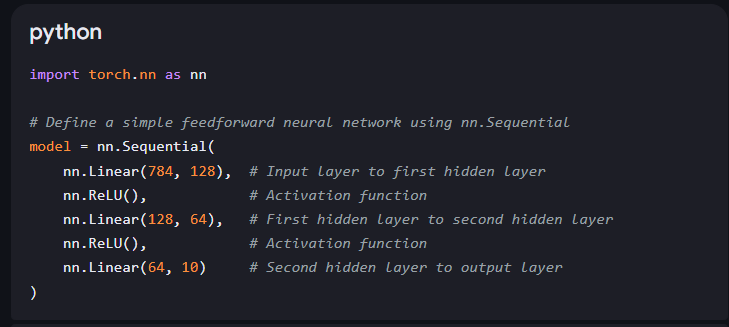

In [12]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, cfg):  # cfg is configuration dictionary
        super().__init__()
        self.layers= nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # Expansion layer
                                   GeluActivation(),  # activation function
                                   nn.Linear(4* cfg["emb_dim"], cfg["emb_dim"])   # Compression layer
                                   )
    def forward(self, x):
        return self.layers(x)

In [13]:
print("Feedforward Network Test")
fn= FeedforwardNetwork(GPT_Config_124M)


Feedforward Network Test


In [14]:
X= torch.rand(2,3,768)  # batch size 2, sequence length 3, embedding dimension 768
out_fn= fn.forward(X)   
print("Feedforward Network output size:", out_fn.size())  # expect (2,3,768)
print("Feedforward Network output:", out_fn)

Feedforward Network output size: torch.Size([2, 3, 768])
Feedforward Network output: tensor([[[-1.5938e-02,  1.3474e-02, -2.1874e-01,  ..., -1.4109e-02,
          -7.8106e-03, -5.7992e-02],
         [-3.0801e-02, -4.9926e-02, -2.8670e-01,  ..., -7.0210e-03,
           3.6155e-02, -3.9049e-02],
         [-1.2934e-01,  2.9413e-02, -3.7849e-01,  ..., -6.0954e-02,
          -4.8549e-02,  1.8631e-02]],

        [[ 9.9368e-03,  8.5113e-02, -2.3261e-01,  ...,  3.5924e-02,
           5.9008e-02,  3.3174e-04],
         [-1.3251e-02,  9.0142e-03, -2.7375e-01,  ...,  6.5309e-02,
           2.8314e-03, -3.0470e-02],
         [-1.8571e-02, -3.8353e-02, -2.3160e-01,  ..., -1.1986e-01,
          -2.5620e-02,  5.5219e-02]]], grad_fn=<ViewBackward0>)


Shortcut connections

In [43]:
class Exampleshortcut(nn.Module):
    def __init__(self, layer_size, use_shortcut=True):
        super().__init__()
        self.use_shortcut= use_shortcut
        self.layers = nn.ModuleList( [
        (nn.Sequential(nn.Linear(layer_size[0], layer_size[1], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[1], layer_size[2], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[2], layer_size[3], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[3], layer_size[4], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[4], layer_size[5], GeluActivation())))
        ])
    def forward(self, x):
        # create an output
        for layer in self.layers:
            layer_output= layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x= layer_output+x  # adding shortcut connection
            
            else:
                x=layer_output
    
        return x            
        

In [114]:
torch.manual_seed(123)
layer_sizes= [2,2,2,2,2,1]
torch.manual_seed(125)
model_shortcut= Exampleshortcut(layer_sizes, use_shortcut=False)
input= torch.tensor([[1.0, -1.0]])


In [15]:
def print_gradients(model,x):
    #forward pass
    output= model(x)
    target= torch.tensor([[0.]])
    loss= nn.MSELoss()(output, target)
    #backward pass
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            #print the mean absolute graidents of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
          

In [118]:
print_gradients(model_shortcut, input)

layers.0.0.weight has gradient mean of 0.5383838415145874
layers.1.0.weight has gradient mean of 0.6849905252456665
layers.2.0.weight has gradient mean of 2.688265562057495
layers.3.0.weight has gradient mean of 1.9808193445205688
layers.4.0.weight has gradient mean of 4.109770774841309


Coding the Transformer architecture 

In [16]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["dropout"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff= FeedforwardNetwork(cfg)
        self.norm1= LayerNormalization(cfg["emb_dim"])
        self.norm2= LayerNormalization(cfg["emb_dim"])
        self.dropout= nn.Dropout(cfg["dropout"])
    
    def forward(self, x):
        shortcut = x
        
        x= self.norm1(x)
        x= self.attention(x)   #shape [batch size, num_tokens, embedding_size ]
        x= self.dropout(x)
        
        x = x + shortcut   # add the original input back
        
        
        # shortcut connection for feedback forward block
        shortcut= x
        
        x= self.norm2(x)
        x = self.ff(x)
        x= self.dropout(x)
        x= x + shortcut
        
        return x
    

In [18]:
torch.manual_seed(123)
x= torch.rand(2,4, 768)    # creting 2 batch of 4 tokens with 768 dimensions
block = TransformerBlock(GPT_Config_124M)
output= block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)



Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Assemble a fully working version of originial 124M parameter version of gpt-2

In [19]:
class DummyGPTv1(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.position_embedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"])   # we are going to look at context length i.e number of words lets say in a sentence we want to know position with is 1024, is context length. 
        self.drop_emb= nn.Dropout(cfg["dropout"])
        
        # Use a placeholder for transformer block
        self.trf_block= nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])  #stacking transformer blocks
        self.final_norm= LayerNormalization(cfg["emb_dim"])
        self.out_layer=nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)   # final output layer to get the probabilities of each token in the vocabulary
    
    
    def forward(self, input):
        batch_size, seq_length = input.shape
        token_emb=self.token_embedding(input)   # we are looking for these inputs in the embedding metrics that we have created
        print("Hers is the token embedding ", token_emb)
        print("token embedding shape:", token_emb.shape)
        position_emb=self.position_embedding(torch.arange(seq_length,device=input.device))  # it will look at the token length (lets say 4) and then find from (0,1,2,3) the position embedding vector for each token from the position embedding matrix defined in class 
        x= token_emb + position_emb
        x=self.drop_emb(x)
        x=self.trf_block(x)   # passing through transformer blocks
        x=self.final_norm(x)
        logits=self.out_layer(x)
        # final output layer
        return logits  #return probabilities of all token in the vocabulary for each Input word position in the sequence to predict what comes next, so size will be token size (here 4) and since dictonary size is 50257, so (4,50257) will be the output size.
        

class LayerNormalization(nn.Module):
    def __init__(self,normalized_shape, eps=0.00001):  # normalized_shape is usually the number of dimesions of embedding 
        # since normalization doesnt change the dimesion 
        super().__init__()
        self.eps= eps
        self.gamma= nn.Parameter(torch.ones(normalized_shape))  # scale parameter
        self.beta= nn.Parameter(torch.zeros(normalized_shape))  # shift parameter
       
    def forward(self, x):
        mean=x.mean(axis=-1, keepdim=True)
        std=x.std(axis=-1, keepdim=True)
        out_normalized= (x - mean) / torch.sqrt (std + self.eps)
        #return out_normalized
        return self.gamma * out_normalized + self.beta  # scale and shift
    
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["dropout"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff= FeedforwardNetwork(cfg)
        self.norm1= LayerNormalization(cfg["emb_dim"])
        self.norm2= LayerNormalization(cfg["emb_dim"])
        self.dropout= nn.Dropout(cfg["dropout"])
    
    def forward(self, x):
        shortcut = x
        
        x= self.norm1(x)
        x= self.attention(x)   #shape [batch size, num_tokens, embedding_size ]
        x= self.dropout(x)
        
        x = x + shortcut   # add the original input back
        
        
        # shortcut connection for feedback forward block
        shortcut= x
        
        x= self.norm2(x)
        x = self.ff(x)
        x= self.dropout(x)
        x= x + shortcut
        
        return x
    
    

In [16]:
torch.manual_seed(123)
model= DummyGPTv1(GPT_Config_124M)


In [19]:
tokenizer= tiktoken.get_encoding("gpt2")
batch=[]
txt1= "Every effort moves you"
txt2= "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch= torch.stack(batch, dim=0) # stacking into batch of size 2
print(batch) 




tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [20]:
print(batch)   

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [68]:
output= model(batch)
print("Output shape:", output.shape)
print("Output logits:", output)


Hers is the token embedding  tensor([[[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]],

        [[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-0.7858,  0.0101,  1.2537,  ..., -0.2667, -0.7853,  1.3047],
         [ 1.8873,  0.7559, -0.1797,  ..., -0.0418, -0.4365, -0.3167],
         [ 1.2758, -0.2896,  0.9539,  ...,  0.3405, -1.0636, -0.0674]]],
       grad_fn=<EmbeddingBackward0>)
token embedding shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])
Output logits: tensor([[[-0.2795,  0.0207, -0.4126,  ...,  0.1579, -0.0857, -0.8874],
         [-0.4371, -0.6535, -1.0686,  ..., -0.8092,  0.5445, -0.4913],
         [ 0.8405, -0.2587,  1.3046,  ...,  0.3142,  0.0232, -0.7656],
         [-1.5843,  0.6129,  0.5889,  ...,  1.3

In [69]:
total_param = sum(p.numel() for p in model.parameters() )
print("Total number of parameters in the model:", total_param)

Total number of parameters in the model: 163009536


In [70]:
print("Token embedding shape:", model.token_embedding.weight.shape)
print("Output layer shape:", model.out_layer.weight.shape)

Token embedding shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [71]:
total_size_bytes = total_param * 4  # assuming 4 bytes per parameter (float32)
total_size_megabytes = total_size_bytes / (1024 ** 2)
print("Total model size (MB):", total_size_megabytes)

Total model size (MB): 621.83203125


In [218]:
garbage = torch.cuda.memory_allocated()
print("Garbage collected memory:", garbage) 

Garbage collected memory: 0


GPT Archtitecture Part 7: Generating Text from Output tokens

Step 1: Idx is a (Batch, n_token ) array of indices in the current context

Step 2:  Crop currrent context if it exceeed the supported context size, if ll, supports only 5 tokens , and the context size is 10 then oly the last 5 tokens are used as  context

Step 3: focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

step 4: probas has shape(batch, vocab_size)

step 5: idx_next has shape( batch,1)

step 6: append smapled index to the running  sequence , where idx has shape (batch, n_tokens)

 logits = logits[:, -1, :]  # (batch, vocab_size) # extract the logits for the last word

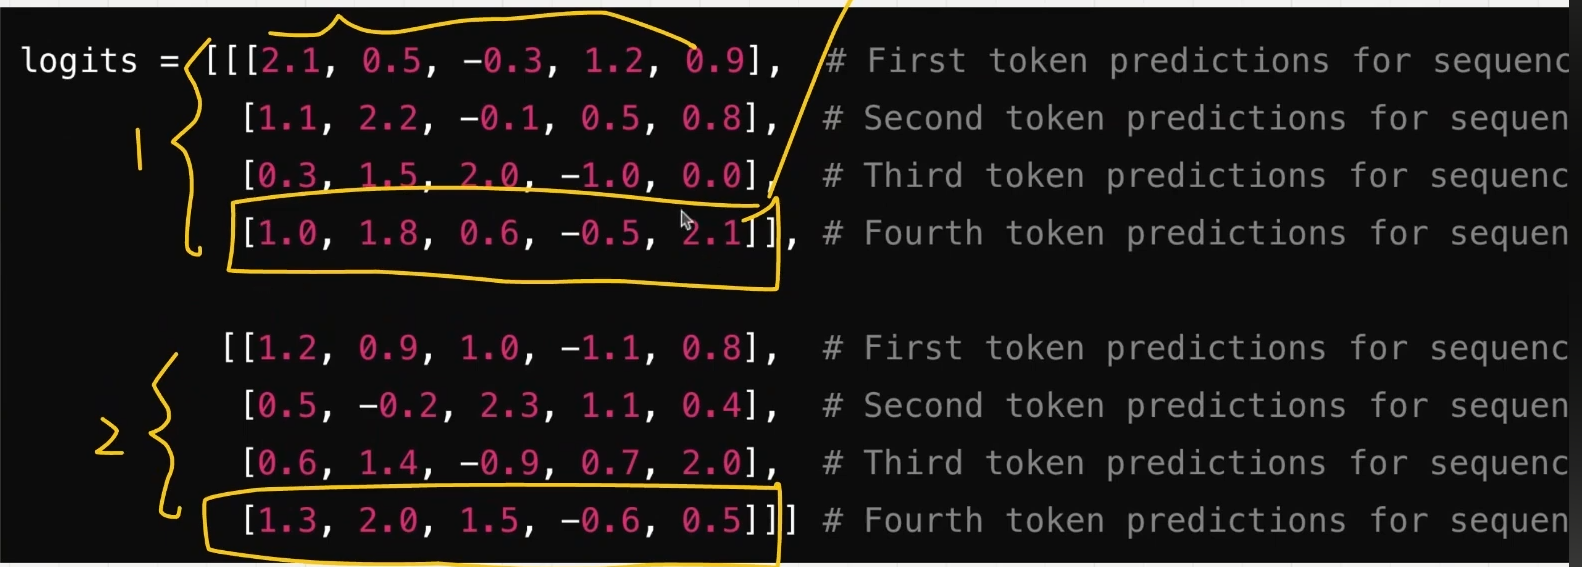

In [20]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    #idx is (batch , n_tokens)
    ### Input batch for our model
    """tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])"""
    # our model only looks at context_size number of tokens at a time to predict the next word
    for _ in range(max_new_tokens):
         # crop idx to the last context_size tokens
        idx_cond = idx[:, -context_size:]  # (batch, context_size)    
         
            # get the predictions
            
        with torch.no_grad():  # no gradient calculation during inference saves memory
            logits = model(idx_cond)  # (batch, context_size, vocab_size)
            # focus only on the last time step
            logits = logits[:, -1, :]  # (batch, vocab_size) # extract the logits for the last row from every batch
            # apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
            
           # get the index of the vocab entru with the highest probablity value
            idx_next= torch.argmax(probs, dim = -1, keepdim=True)
           
           # append sampled index to the running sequence i.e to the previous input
           
            idx= torch.cat((idx, idx_next), dim=1)  # concatenate along the sequence dimension
    return idx  
        
        
    
    

In [22]:
import tiktoken

encoder= tiktoken.get_encoding("gpt2")

In [23]:
start_context = "Hello , I am"

encoded= encoder.encode(start_context)

print("encoded:", encoded)

encoded_tensor= torch.tensor(encoded).unsqueeze(0)  # adding batch dimension
print("encoded tensor:", encoded_tensor.shape)








encoded: [15496, 837, 314, 716]
encoded tensor: torch.Size([1, 4])


In [24]:
model.eval()  # set the model to evaluation mode # which disables dropout layers , which are only used during training to prevent lazy neuron problem
out = generate_text_simple(model, encoded_tensor, max_new_tokens=5, context_size= GPT_Config_124M["context_length"])

print("Output:", out)



print("Output length:", out.shape)

Hers is the token embedding  tensor([[[ 2.1041,  1.2950,  0.7809,  ...,  0.0410, -1.2561,  0.5861],
         [ 0.3028,  0.0802,  0.9890,  ...,  1.6838, -0.5011, -0.5583],
         [-1.6306, -0.0663, -0.1199,  ..., -0.5732,  0.8276,  0.0805],
         [-1.1948, -0.0317, -0.8137,  ..., -0.4624, -1.5515, -0.2633]]])
token embedding shape: torch.Size([1, 4, 768])
Hers is the token embedding  tensor([[[ 2.1041,  1.2950,  0.7809,  ...,  0.0410, -1.2561,  0.5861],
         [ 0.3028,  0.0802,  0.9890,  ...,  1.6838, -0.5011, -0.5583],
         [-1.6306, -0.0663, -0.1199,  ..., -0.5732,  0.8276,  0.0805],
         [-1.1948, -0.0317, -0.8137,  ..., -0.4624, -1.5515, -0.2633],
         [ 1.5149,  2.3292, -0.1026,  ...,  0.7384, -2.1510, -0.1495]]])
token embedding shape: torch.Size([1, 5, 768])
Hers is the token embedding  tensor([[[ 2.1041,  1.2950,  0.7809,  ...,  0.0410, -1.2561,  0.5861],
         [ 0.3028,  0.0802,  0.9890,  ...,  1.6838, -0.5011, -0.5583],
         [-1.6306, -0.0663, -0.119

In [25]:
print("Generated text:", encoder.decode(out[0].tolist()))  # decode the first batch output to text

Generated text: Hello , I amretch soared Bangkok ways BUT


Measuring the loss of LLM model

In [21]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 256,  # maximum context length meaning number of tokens in a sequence(1024 for gpt2)   #reduced context length for faster testing
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

In [27]:
import tiktoken 


def text_to_token_id(text, tokenizer):
    encode = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encode).unsqueeze(0)  # adding batch dimension

def token_id_to_text(token_ids, tokenizer):
    token_ids = token_ids.squeeze(0).tolist()  # remove batch dimension and convert to list
    return tokenizer.decode(token_ids)

start_context= " Every effort moves you"

tokenizer= tiktoken.get_encoding("gpt2")

model_ids = generate_text_simple(
    model= model,
    idx = text_to_token_id(start_context, tokenizer),
    max_new_tokens = 10,
    context_size= GPT_Config_124M["context_length"]
    

)

print("Output text:", token_id_to_text(model_ids, tokenizer))

Hers is the token embedding  tensor([[[ 0.2852,  0.8703, -1.1740,  ..., -0.0807, -0.3314, -0.2349],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]]])
token embedding shape: torch.Size([1, 4, 768])
Hers is the token embedding  tensor([[[ 0.2852,  0.8703, -1.1740,  ..., -0.0807, -0.3314, -0.2349],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841],
         [-0.2686, -1.4262,  0.3932,  ..., -0.2436, -0.1946,  1.0348]]])
token embedding shape: torch.Size([1, 5, 768])
Hers is the token embedding  tensor([[[ 0.2852,  0.8703, -1.1740,  ..., -0.0807, -0.3314, -0.2349],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.225

In [28]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [29]:
with torch.no_grad():
    logits = model(inputs)
prob= torch.softmax(logits, dim = -1)
print("Probabilities shape:", prob.shape)  # expect (2, 3, 50257)
print("Probabilities:", prob)

Hers is the token embedding  tensor([[[-0.9210,  1.3757, -1.7958,  ..., -0.6863,  0.3287,  0.5574],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774]],

        [[-1.0568, -0.0297,  0.5009,  ..., -2.3270,  0.2427, -1.0479],
         [-0.8354,  1.4412, -0.2433,  ..., -0.7709, -0.4333, -0.4383],
         [-1.4362, -0.8026,  0.8956,  ...,  1.6988, -1.4694,  0.0729]]])
token embedding shape: torch.Size([2, 3, 768])
Probabilities shape: torch.Size([2, 3, 50257])
Probabilities: tensor([[[1.0664e-05, 5.3031e-06, 2.0179e-05,  ..., 1.9159e-05,
          3.4301e-05, 2.0879e-06],
         [1.3322e-05, 3.8189e-06, 5.6105e-06,  ..., 8.9357e-06,
          3.2049e-05, 8.9752e-06],
         [4.6325e-05, 8.3857e-06, 2.1280e-05,  ..., 1.2349e-05,
          1.2745e-05, 9.9791e-06]],

        [[2.4027e-05, 1.3306e-05, 5.3609e-05,  ..., 7.1235e-06,
          3.7344e-05, 3.5331e-06],
         [1.3993e-05, 2.4640e-05, 

In [30]:
token_id = torch.argmax(prob, dim=-1)
print("Predicted token IDs:", token_id)

Predicted token IDs: tensor([[36397, 32780, 21515],
        [ 9814, 49289, 38737]])


lets find the target probabilities

In [31]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [32]:

torch.set_printoptions(sci_mode=False)  # get inputs in non scientific notation

In [33]:
text_idx=0   #first bactch
target_probabs_1 = prob[text_idx, [0,1,2], targets[text_idx]]     # from  prob matrix we are extracting the prob of row 0 ,1 2 and from row 0 we are getting value corresponding to index 3626,  6100 from row 2 ,345 from row 

print("Target probabilities for first batch:", target_probabs_1)


text_idx=1   #second batch
target_probabs_2 = prob[text_idx, [0,1,2], targets[text_idx]]

print("Target probabilities for second batch:", target_probabs_1)

Target probabilities for first batch: tensor([    0.0000,     0.0000,     0.0000])
Target probabilities for second batch: tensor([    0.0000,     0.0000,     0.0000])


we need to get these probablities close to zero

In [35]:
log_prob = torch.log(torch.cat((target_probabs_1, target_probabs_2)))  # concatenating both batch probabilities and computing log of all token probabilities

print("Log probabilities of target tokens:", log_prob)
                    

Log probabilities of target tokens: tensor([-10.8547, -10.9186, -11.8215,  -9.8515, -11.2865, -11.6848])


Now we compute the avearge prob 

In [37]:
log_prob = torch.mean(log_prob)  # averaging log probabilities over all target tokens
print("Average log probability of target tokens:", log_prob)

Average log probability of target tokens: tensor(-11.0696)


In [38]:
# negative of average log probability is cross entropy loss 
cross_entropy_loss = -log_prob
print("Cross Entropy Loss:", cross_entropy_loss)

Cross Entropy Loss: tensor(11.0696)


In [39]:
print("logits_shape", logits.shape)
print("target_shape", targets.shape)

logits_shape torch.Size([2, 3, 50257])
target_shape torch.Size([2, 3])


Flatten the  logits to make it into a matricx of 6 *50257 

In [41]:
logits_flat= torch.flatten(logits, start_dim=0, end_dim=1)  # flattening batch and sequence dimensions
targets_flat= torch.flatten(targets)  # flattening targets

print("logits_flat shape:", logits_flat.shape)
print("targets_flat shape:", targets_flat.shape)

logits_flat shape: torch.Size([6, 50257])
targets_flat shape: torch.Size([6])


In [43]:
loss=torch.nn.functional.cross_entropy(logits_flat, targets_flat)  # computing cross entropy loss using pytorch function
print("Cross Entropy Loss using PyTorch function:", loss)

Cross Entropy Loss using PyTorch function: tensor(11.0696)


We need to try to get this loss to as close to zero as possible

### Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>

In [44]:
perplexity= torch.exp(loss)
print("Perplexity of the model on the given input:", perplexity)

Perplexity of the model on the given input: tensor(64189.3438)


Evaluating LLM performance on real dataset

In [28]:
import os


file_path = "D:/New Projects/LLM/Data_the_Verdict/Data.txt"  # adjust the path as needed
with open(file_path, 'r', encoding='utf-8') as f:
    text_data = f.read()
print("text_data :", text_data[:100])

text_data : I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [30]:
import tiktoken

tokenizer= tiktoken.get_encoding("gpt2")

In [31]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data)) 
print("Total characters:", total_characters)
print("Total tokens:", total_tokens)

Total characters: 20482
Total tokens: 5147


Divide the data into training and validation sets

In [37]:
from matplotlib import text
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, strides):  # max_length is context length, strides is the step size for sliding window
        self.input_id=[]
        self.target=[]
        
        #tokenize the entire text
        
        token_ids = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        
        # use a sliding window approach to create input-target pairs
        for i in range(0, len(token_ids)- max_length, strides):
            input_chunk = token_ids[i: i+max_length]
            target_chunk = token_ids[i+1: i+max_length +1]
            self.input_id.append(torch.tensor(input_chunk))
            self.target.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_id)
    
    def __getitem__(self, idx):
        return self.input_id[idx], self.target[idx]
    
def create_dataloader_v1(txt, batch_size=4, max_length= 256, strides = 128, shuffle = True, drop_last = True, num_workers=0): # if drop_last is true then last left over batch will be dropped if its size is less than batch size
    
    tokenizer= tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, strides)
    dataloder= DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    
    return dataloder

In [48]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 256,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

In [49]:
train_ratio = 0.90
split_idx= int(len(text_data) * train_ratio)
train_data= text_data[: split_idx]
val_data= text_data[split_idx:]

torch.manual_seed(123)
train_dataloader= create_dataloader_v1(train_data, batch_size= 2,
                                    max_length= GPT_Config_124M["context_length"],
                                    strides=GPT_Config_124M["context_length"],
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=0)


val_dataloader= create_dataloader_v1(val_data, batch_size= 2,
                                    max_length= GPT_Config_124M["context_length"],
                                    strides=GPT_Config_124M["context_length"],
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=0)

In [51]:
if total_tokens * train_ratio // GPT_Config_124M["context_length"] < 10:
    print("Warning: The training dataset is very small. Consider using a larger dataset or smaller context length for   meaningful training.")
    print("Number of training batches:", len(train_dataloader))
    print("Number of validation batches:", len(val_dataloader))
    
if total_tokens * (1 - train_ratio) // GPT_Config_124M["context_length"] < 10:
    print("Warning: The validation dataset is very small. Consider using a larger dataset or smaller context length for meaningful validation.")
    print("Number of training batches:", len(train_dataloader))
    print("Number of validation batches:", len(val_dataloader))

Number of training batches: 9
Number of validation batches: 1


In [56]:
print( "Number of training batches:", len(train_dataloader))
for x, y in train_dataloader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)  # just to show one batch
print( "Number of validation batches:", len(val_dataloader))    

for x, y in val_dataloader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)  # just to show one batch

Number of training batches: 9
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Number of validation batches: 1
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
